# Descriptive statistics - Canopy closure (CC) Maps

- Project:     cercospoRa
- Script:      04_desc_stats_cc_cercospoRa.ipynb
- Author:      Rene Heim
- Affiliation: University of Goettingen
- Date:        2025-11-22

**Objective:** This notebook provides descriptive statistics of canopy closure dates to understand the distribution and characteristics of LAI values.

**Data:** CC maps were generated using PROSAIL generated LAI maps.

**Methods:** This notebook will explore the following aspects of the CC maps:

* Distribution of CC values
* Summary statistics (e.g., mean, median, standard deviation)

**Notebook Structure:** This notebook is organized into the following sections:

1. Data Import and Preparation
2. Descriptive Statistics

### 1. Set up environment

**Note:** For reproducible installation of dependencies using `%conda install`, please open this notebook in Jupyter Notebook or JupyterLab. Magic commands may not function as expected in other Python environments or editors.

In [5]:
#%conda install numpy pandas geopandas rasterio rioxarray shapely matplotlib seaborn session-info2

In [6]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import pandas as pd
from shapely.geometry import Point
import datetime as dt
from session_info2 import session_info
session_info(dependencies=True)

C:\Users\reneh\AppData\Local\Temp\ipykernel_5328\3932593585.py:13: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  session_info(dependencies=True)


Package,Version
seaborn,0.13.2
matplotlib,3.10.6
numpy,2.3.5
geopandas,1.1.1
rioxarray,0.18.1
pandas,2.3.3
shapely,2.1.1
xarray,2025.10.1
Component,Info
Python,"3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:09:58) [MSC v.1929 64 bit (AMD64)]"


In [7]:
os.chdir(r'C:\Users\reneh\Desktop\test_repro\cercospoRa_compendium')
current_date = dt.date.today()
out = r"C:\Users\reneh\Desktop\test_repro\cercospoRa_compendium\output"

### 2. Import raster and vector data

In [8]:
treated_ino = r"data\20250504_treated_ino.gpkg"
untreated_ino = r"data\20250504_untreated_ino.gpkg"

treated_roi = r"data\20250504_treated_roi_diff.gpkg"
untreated_roi = r"data\20250504_untreated_roi_diff.gpkg"

# Load the raster file
cc_uas = r"output\cc_maps\uas_cc.tif"
cc_s2 = r"output\cc_maps\s2_cc.tif"
cc_s2s = r"output\cc_maps\s2_superresolution_cc.tif"

# Load the polygon layers
treated_ino = gpd.read_file(treated_ino)
untreated_ino = gpd.read_file(untreated_ino)

treated_roi = gpd.read_file(treated_roi)
untreated_roi = gpd.read_file(untreated_roi)

cc_uas = rxr.open_rasterio(cc_uas)
cc_s2 = rxr.open_rasterio(cc_s2)
cc_s2s = rxr.open_rasterio(cc_s2s)

print(f"⚠️ UAS canopy closure raster CRS: {cc_uas.rio.crs}")
print(f"⚠️ S2 canopy closure raster CRS: {cc_s2.rio.crs}")
print(f"⚠️ S2S canopy closure raster CRS: {cc_s2s.rio.crs}")

⚠️ UAS canopy closure raster CRS: EPSG:32632
⚠️ S2 canopy closure raster CRS: EPSG:32632
⚠️ S2S canopy closure raster CRS: EPSG:32632


### 3. Reproject CRS

In [9]:
#cc_uas = cc_uas.rio.reproject("EPSG:32632")

#print(f"⚠️ UAS reprojected raster CRS: {cc_uas.rio.crs}")

In [10]:
treated_ino = treated_ino.to_crs(32632)
untreated_ino = untreated_ino.to_crs(32632)

treated_roi = treated_roi.to_crs(32632)
untreated_roi = untreated_roi.to_crs(32632)

print(f"⚠️ Treated inoculation area CRS: {treated_ino.crs}")
print(f"⚠️ Unreated inoculation area CRS: {untreated_ino.crs}")

print(f"⚠️ Treated ROI CRS: {treated_roi.crs}")
print(f"⚠️ Untreated ROI CRS: {untreated_roi.crs}")

⚠️ Treated inoculation area CRS: EPSG:32632
⚠️ Unreated inoculation area CRS: EPSG:32632
⚠️ Treated ROI CRS: EPSG:32632
⚠️ Untreated ROI CRS: EPSG:32632


### 4. Handle no data values

In [11]:
print(f"⚠️ UAS no data value is: {cc_uas.rio.nodata}")
print(f"⚠️ S2 no data value is: {cc_s2.rio.nodata}")
print(f"⚠️ S2S no data value is: {cc_s2s.rio.nodata}")

⚠️ UAS no data value is: 4294967295
⚠️ S2 no data value is: 4294967295
⚠️ S2S no data value is: 4294967295


In [12]:
cc_uas = cc_uas.where(cc_uas <= 2000)
cc_uas.rio.write_nodata(np.nan, inplace=True)

cc_s2 = cc_s2.where(cc_s2 <= 2000)
cc_s2.rio.write_nodata(np.nan, inplace=True)

cc_s2s = cc_s2s.where(cc_s2s <= 2000)
cc_s2s.rio.write_nodata(np.nan, inplace=True)

print(f"⚠️ UAS no data value is: {cc_uas.rio.nodata}")
print(f"⚠️ S2 no data value is: {cc_s2.rio.nodata}")
print(f"⚠️ S2S no data value is: {cc_s2s.rio.nodata}")

⚠️ UAS no data value is: nan
⚠️ S2 no data value is: nan
⚠️ S2S no data value is: nan


### 4. Verify location of vector layers

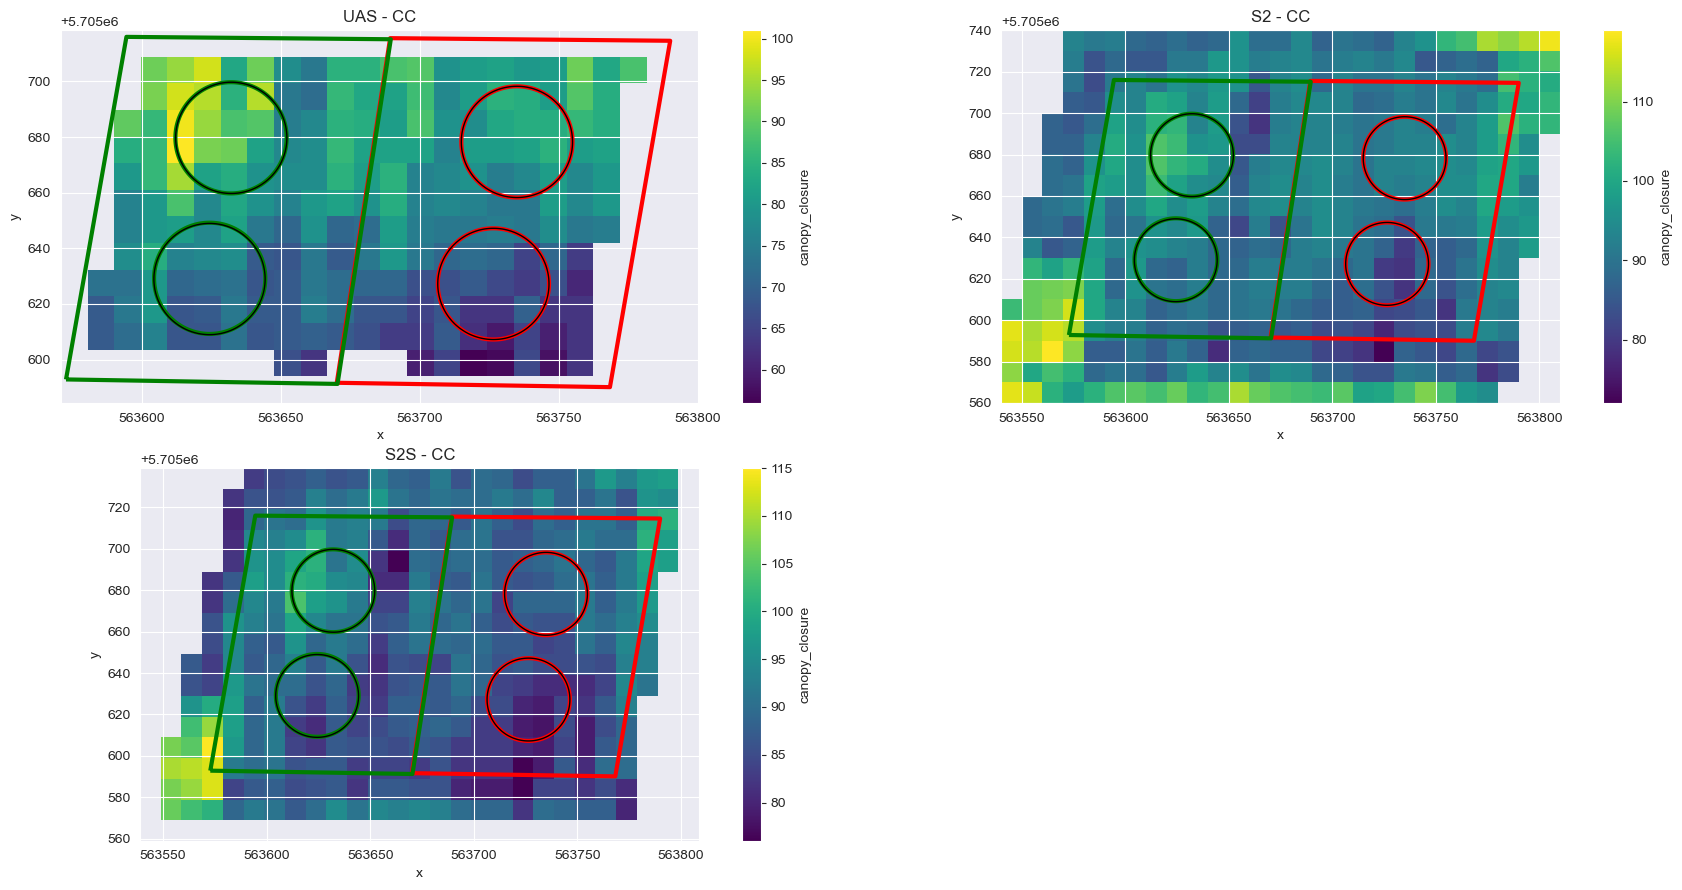

In [13]:
# Create a figure with a 2x3 subplot grid
fig = plt.figure(figsize=(18, 9))

# Create a gridspec with 2 columns and 3 rows
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])


# UAS - CC
cc_uas.isel(band=0).plot.imshow(ax=ax1, cmap="viridis")
treated_roi.boundary.plot(ax=ax1, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax1, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)

ax1.set_title("UAS - CC")

# S2 - CC
cc_s2.isel(band=0).plot.imshow(ax=ax2, cmap="viridis")
treated_roi.boundary.plot(ax=ax2, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax2, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax2, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax2, edgecolor='black', linewidth=1)

ax2.set_title("S2 - CC")

# S2S - CC
cc_s2s.isel(band=0).plot.imshow(ax=ax3, cmap="viridis")
treated_roi.boundary.plot(ax=ax3, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax3, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax3, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax3, edgecolor='black', linewidth=1)

ax3.set_title("S2S - CC")


# Layout so plots do not overlap
fig.tight_layout()
plt.savefig(os.path.join(out, f"{current_date}_plot_vectorcheck_cc.png"), dpi=600, bbox_inches='tight')
plt.show()

### 5. Extract UAS-derived CC values

In [14]:
def extract_raster_data(uas_1_rp, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="df_", value_column="values"):
    extractions = [
        (treated_roi,    "treated",   "non-inoculated"),
        (untreated_roi,  "untreated", "non-inoculated"),
        (treated_ino,    "treated",   "inoculated"),
        (untreated_ino,  "untreated", "inoculated")
    ]

    dfs = []

    for poly, treatment, region in extractions:
        clipped = uas_1_rp.rio.clip(poly.geometry, poly.crs, drop=True).isel(band=0)
        values = clipped.values.flatten()
        mask = ~np.isnan(values)
        values = values[mask]

        y_coords, x_coords = np.meshgrid(clipped['y'].values, clipped['x'].values, indexing='ij')
        x_flat = x_coords.flatten()[mask]
        y_flat = y_coords.flatten()[mask]

        df = pd.DataFrame({
            "x": x_flat,
            "y": y_flat,
            value_column: values,
            "treatment": treatment,
            "area": region,
            "source": df_name
        })

        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    return df

In [15]:
df_uas_cc = extract_raster_data(cc_uas, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="uas", value_column="cc")
df_uas_cc

,x,y,cc,treatment,area,source
0,563690.451377,5.705704e+06,88.0,treated,non-inoculated,uas
1,563700.023732,5.705704e+06,89.0,treated,non-inoculated,uas
2,563709.596087,5.705704e+06,79.0,treated,non-inoculated,uas
3,563719.168442,5.705704e+06,81.0,treated,non-inoculated,uas
4,563728.740797,5.705704e+06,82.0,treated,non-inoculated,uas
...,...,...,...,...,...,...
211,563633.017248,5.705627e+06,73.0,untreated,inoculated,uas
212,563642.589603,5.705627e+06,68.0,untreated,inoculated,uas
213,563613.872538,5.705618e+06,68.0,untreated,inoculated,uas
214,563623.444893,5.705618e+06,69.0,untreated,inoculated,uas


### 5. Extract S2-derived CC values

In [16]:
df_s2_cc = extract_raster_data(cc_s2, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2", value_column="cc")
df_s2_cc

,x,y,cc,treatment,area,source
0,563695.0,5705715.0,88.0,treated,non-inoculated,s2
1,563705.0,5705715.0,93.0,treated,non-inoculated,s2
2,563715.0,5705715.0,90.0,treated,non-inoculated,s2
3,563725.0,5705715.0,90.0,treated,non-inoculated,s2
4,563735.0,5705715.0,93.0,treated,non-inoculated,s2
...,...,...,...,...,...,...
246,563625.0,5705625.0,87.0,untreated,inoculated,s2
247,563635.0,5705625.0,92.0,untreated,inoculated,s2
248,563615.0,5705615.0,90.0,untreated,inoculated,s2
249,563625.0,5705615.0,89.0,untreated,inoculated,s2


### 5. Extract S2S-derived CC values

In [17]:
df_s2s_cc = extract_raster_data(cc_s2s, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2s", value_column="cc")
df_s2s_cc

,x,y,cc,treatment,area,source
0,563694.0,5705714.0,87.0,treated,non-inoculated,s2s
1,563704.0,5705714.0,91.0,treated,non-inoculated,s2s
2,563714.0,5705714.0,88.0,treated,non-inoculated,s2s
3,563724.0,5705714.0,85.0,treated,non-inoculated,s2s
4,563734.0,5705714.0,90.0,treated,non-inoculated,s2s
...,...,...,...,...,...,...
250,563624.0,5705624.0,83.0,untreated,inoculated,s2s
251,563634.0,5705624.0,88.0,untreated,inoculated,s2s
252,563614.0,5705614.0,83.0,untreated,inoculated,s2s
253,563624.0,5705614.0,81.0,untreated,inoculated,s2s


### 8. Concatenate and clean dataframes

In [18]:
# Concatenate the individual DataFrames (df_s2_prediction, df_uav_prediction, etc.)
df_all = pd.concat([df_uas_cc, df_s2_cc, df_s2s_cc], ignore_index=True)

df_all.to_csv(os.path.join(out, f"{current_date}_fulldf_cc_cercospoRa.csv"), index=False)

df_untreated = df_all[df_all["treatment"] == "untreated"]
df_untreated["source"] = df_untreated["source"].str.upper()

# Show the resulting DataFrame
df_untreated

C:\Users\reneh\AppData\Local\Temp\ipykernel_5328\153568988.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_untreated["source"] = df_untreated["source"].str.upper()


,x,y,cc,treatment,area,source
82,563604.300183,5.705704e+06,91.0,untreated,non-inoculated,UAS
83,563613.872538,5.705704e+06,94.0,untreated,non-inoculated,UAS
84,563623.444893,5.705704e+06,98.0,untreated,non-inoculated,UAS
85,563633.017248,5.705704e+06,83.0,untreated,non-inoculated,UAS
86,563642.589603,5.705704e+06,91.0,untreated,non-inoculated,UAS
...,...,...,...,...,...,...
717,563624.000000,5.705624e+06,83.0,untreated,inoculated,S2S
718,563634.000000,5.705624e+06,88.0,untreated,inoculated,S2S
719,563614.000000,5.705614e+06,83.0,untreated,inoculated,S2S
720,563624.000000,5.705614e+06,81.0,untreated,inoculated,S2S


### 9. Summarize CC (untreated) data

In [19]:
# Group and summarize
summary = df_untreated.groupby(['area', 'source'])['cc'].describe().round(2)

# Optional: reset index for flat table display
summary = summary.reset_index()
#summary["source"] = summary["source"].str.upper()
summary.columns = ['Sample Area', 'Sample Platform', "Count", "Mean", "SD", "Min", "Q1", "Median", "Q3", "Max"]

# Save the summary to a CSV file
summary.to_csv(os.path.join(out, f"{current_date}_summary_desc_stats_cc_cercospoRa.csv"), index=False)

# Display the summary (optional)
summary

,Sample Area,Sample Platform,Count,Mean,SD,Min,Q1,Median,Q3,Max
0,inoculated,S2,27.0,96.00,5.23,87.0,92.50,95.0,98.5,106.0
1,inoculated,S2S,26.0,91.85,5.95,81.0,87.25,91.5,95.0,104.0
2,inoculated,UAS,27.0,81.96,10.20,68.0,73.50,82.0,90.0,101.0
3,non-inoculated,S2,99.0,92.52,6.02,79.0,88.00,93.0,95.5,116.0
4,non-inoculated,S2S,99.0,89.38,5.44,76.0,86.00,89.0,92.0,113.0
5,non-inoculated,UAS,80.0,78.30,7.79,63.0,72.00,78.0,84.0,98.0


In [20]:
from great_tables import GT

cc_table = (
    GT(summary)
    .tab_header(title="Descriptive Canopy Closure Statistics")
    )

#lai_table.save("output/lai_table.png",
#               selector = "table",
#               scale = 2,
#               web_driver= "firefox"
#               )

cc_table

GT(_tbl_data=      Sample Area Sample Platform  Count   Mean     SD   Min     Q1  Median  \
0      inoculated              S2   27.0  96.00   5.23  87.0  92.50    95.0   
1      inoculated             S2S   26.0  91.85   5.95  81.0  87.25    91.5   
2      inoculated             UAS   27.0  81.96  10.20  68.0  73.50    82.0   
3  non-inoculated              S2   99.0  92.52   6.02  79.0  88.00    93.0   
4  non-inoculated             S2S   99.0  89.38   5.44  76.0  86.00    89.0   
5  non-inoculated             UAS   80.0  78.30   7.79  63.0  72.00    78.0   

     Q3    Max  
0  98.5  106.0  
1  95.0  104.0  
2  90.0  101.0  
3  95.5  116.0  
4  92.0  113.0  
5  84.0   98.0  , _body=<great_tables._gt_data.Body object at 0x000001EA24CF2900>, _boxhead=Boxhead([ColInfo(var='Sample Area', type=<ColInfoTypeEnum.default: 1>, column_label='Sample Area', column_align='left', column_width=None), ColInfo(var='Sample Platform', type=<ColInfoTypeEnum.default: 1>, column_label='Sample Platform', column_align='left', column_width=None), ColInfo(var='Count', type=<ColInfoTypeEnum.default: 1>, column_label='Count', column_align='right', column_width=None), ColInfo(var='Mean', type=<ColInfoTypeEnum.default: 1>, column_label='Mean', column_align='right', column_width=None), ColInfo(var='SD', type=<ColInfoTypeEnum.default: 1>, column_label='SD', column_align='right', column_width=None), ColInfo(var='Min', type=<ColInfoTypeEnum.default: 1>, column_label='Min', column_align='right', column_width=None), ColInfo(var='Q1', type=<ColInfoTypeEnum.default: 1>, column_label='Q1', column_align='right', column_width=None), ColInfo(var='Median', type=<ColInfoTypeEnum.default: 1>, column_label='Median', column_align='right', column_width=None), ColInfo(var='Q3', type=<ColInfoTypeEnum.default: 1>, column_label='Q3', column_align='right', column_width=None), ColInfo(var='Max', type=<ColInfoTypeEnum.default: 1>, column_label='Max', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001EA24CF2510>, _spanners=Spanners([]), _heading=Heading(title='Descriptive Canopy Closure Statistics', subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x000001EA24CF2CF0>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x000001EA2653D310>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001EA24CF2E40>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=Op

### 10. Verify position of extracted coordinates

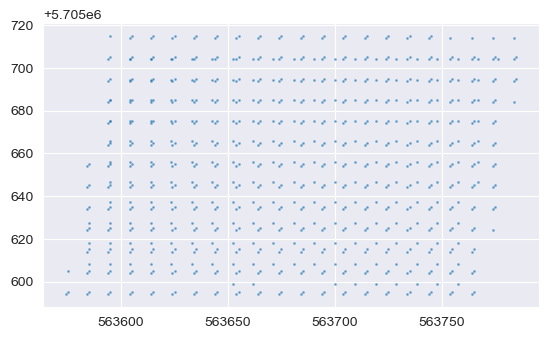

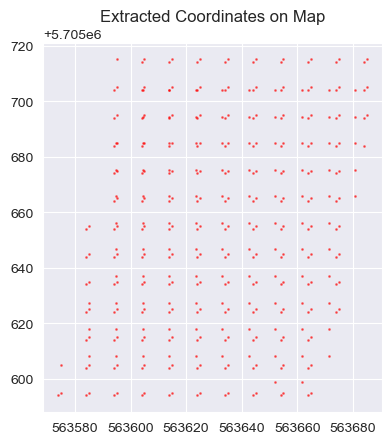

In [21]:
# Create geometry column from x and y
geometry = [Point(xy) for xy in zip(df_all["x"], df_all["y"])]
geometry_un = [Point(xy) for xy in zip(df_untreated["x"], df_untreated["y"])]
gdf = gpd.GeoDataFrame(df_all, geometry=geometry, crs="EPSG:32633")  # Replace with your CRS
gdf_un = gpd.GeoDataFrame(df_untreated, geometry=geometry_un, crs="EPSG:32633")  # Replace with your CRS
# Plot
gdf.plot(markersize=1, alpha=0.5)
gdf_un.plot(markersize=1, alpha=0.5, color="red")
plt.title("Extracted Coordinates on Map")
plt.show()

### 11. Visualize untreated canopy closure data

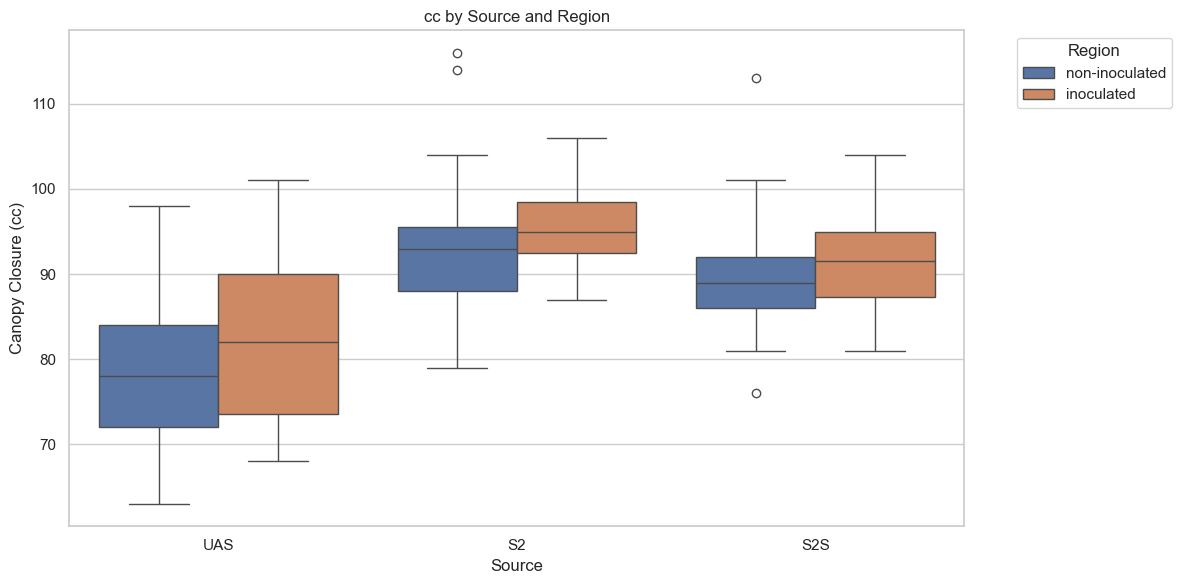

In [22]:
# Set plot style
sns.set(style="whitegrid")

# Create a boxplot of LAI by source and region
plt.figure(figsize=(12, 6))
sns.boxplot(x="source", y="cc", hue="area", data=df_untreated)

# Add titles and labels
plt.title("cc by Source and Region")
plt.xlabel("Source")
plt.ylabel("Canopy Closure (cc)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [23]:
# Inoculated Area

median_uas_ino = summary.loc[
    (summary['Sample Area'] == 'inoculated') & (summary['Sample Platform'] == 'UAS'), 'Median'
].values[0]

median_s2_ino = summary.loc[
    (summary['Sample Area'] == 'inoculated') & (summary['Sample Platform'] == 'S2'), 'Median'
].values[0]

median_s2s_ino = summary.loc[
    (summary['Sample Area'] == 'inoculated') & (summary['Sample Platform'] == 'S2S'), 'Median'
].values[0]

# Non-inoculated Area

median_uas_nino = summary.loc[
    (summary['Sample Area'] == 'non-inoculated') & (summary['Sample Platform'] == 'UAS'), 'Median'
].values[0]

median_s2_nino = summary.loc[
    (summary['Sample Area'] == 'non-inoculated') & (summary['Sample Platform'] == 'S2'), 'Median'
].values[0]

median_s2s_nino = summary.loc[
    (summary['Sample Area'] == 'non-inoculated') & (summary['Sample Platform'] == 'S2S'), 'Median'
].values[0]

print(median_uas_ino, median_s2_ino, median_s2s_ino, median_uas_nino, median_s2_nino, median_s2s_nino)

82.0 95.0 91.5 78.0 93.0 89.0


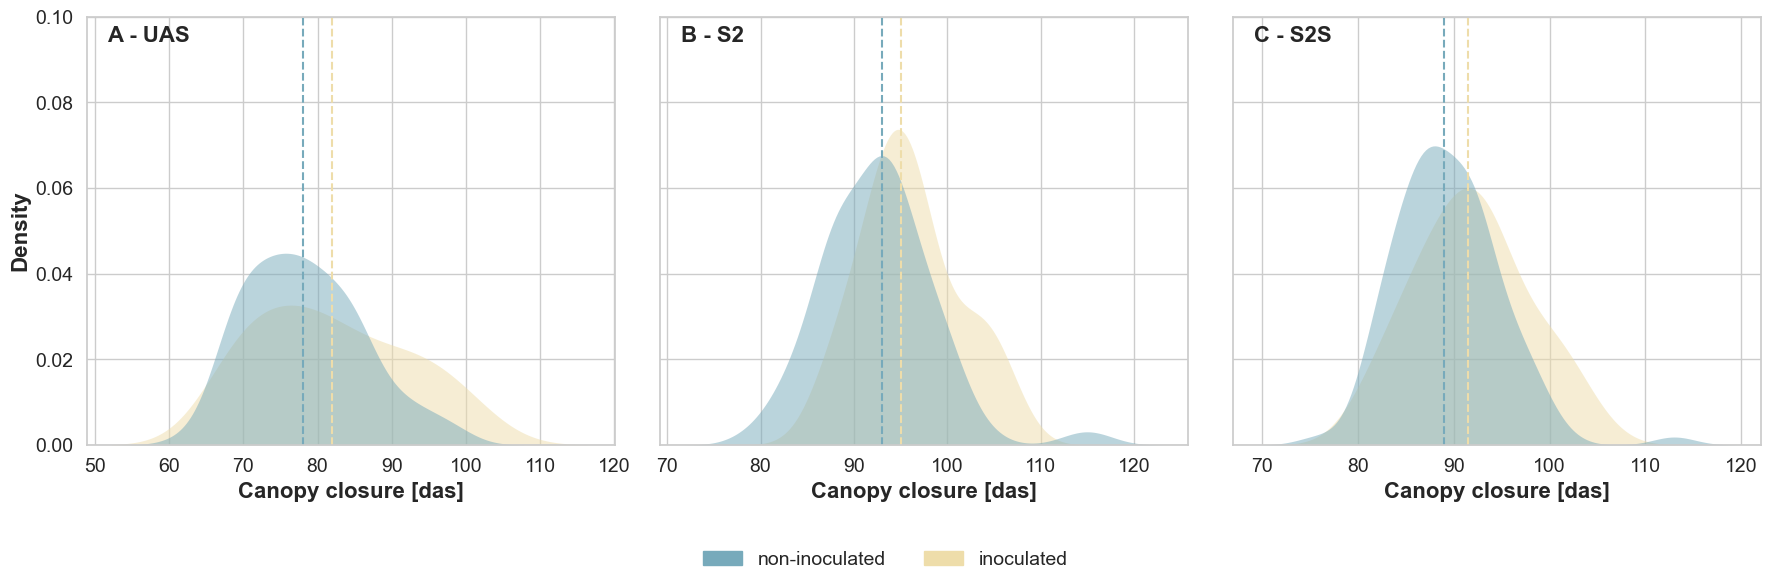

In [24]:
from matplotlib import rcParams

# Set publication-style fonts and seaborn theme
sns.set_style("whitegrid")
rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

# Prepare data
df_uas = df_untreated[df_untreated["source"] == "UAS"]
df_s2 = df_untreated[df_untreated["source"] == "S2"]
df_s2s = df_untreated[df_untreated["source"] == "S2S"]

# Color palette by area
area = df_uas["area"].unique()
palette = sns.color_palette("blend:#7AB,#EDA", n_colors=len(area))
area_colors = dict(zip(area, palette))

# Set up subplots
fig, axs = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)

# Define common plotting function
def plot_kde(ax, data, median_nino, median_ino, label):
    sns.kdeplot(
        data=data, x="cc", hue="area", fill=True, common_norm=False,
        palette=area_colors, alpha=0.5, linewidth=0, ax=ax, legend=False
    )
    ax.set_ylim(0, 0.1)
    ax.axvline(median_nino, color=area_colors[area[0]], linestyle='--')
    ax.axvline(median_ino, color=area_colors[area[1]], linestyle='--')
    ax.text(0.04, 0.98, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')
    ax.set_ylabel("Density", fontsize=16, fontweight='bold')
    ax.set_xlabel("Canopy closure [das]", fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=14)

# Apply to each subplot
plot_kde(axs[0], df_uas, median_uas_nino, median_uas_ino, 'A - UAS')
plot_kde(axs[1], df_s2, median_s2_nino, median_s2_ino, 'B - S2')
plot_kde(axs[2], df_s2s, median_s2s_nino, median_s2s_ino, 'C - S2S')

# Add legend
handles = [mpatches.Patch(color=color, label=label) for label, color in area_colors.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(area), frameon=False, fontsize=14)

# Final layout adjustments
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig(os.path.join(out, f"{current_date}_plot_kde_cc_cercospoRa.png"), dpi=600, bbox_inches='tight')
plt.show()


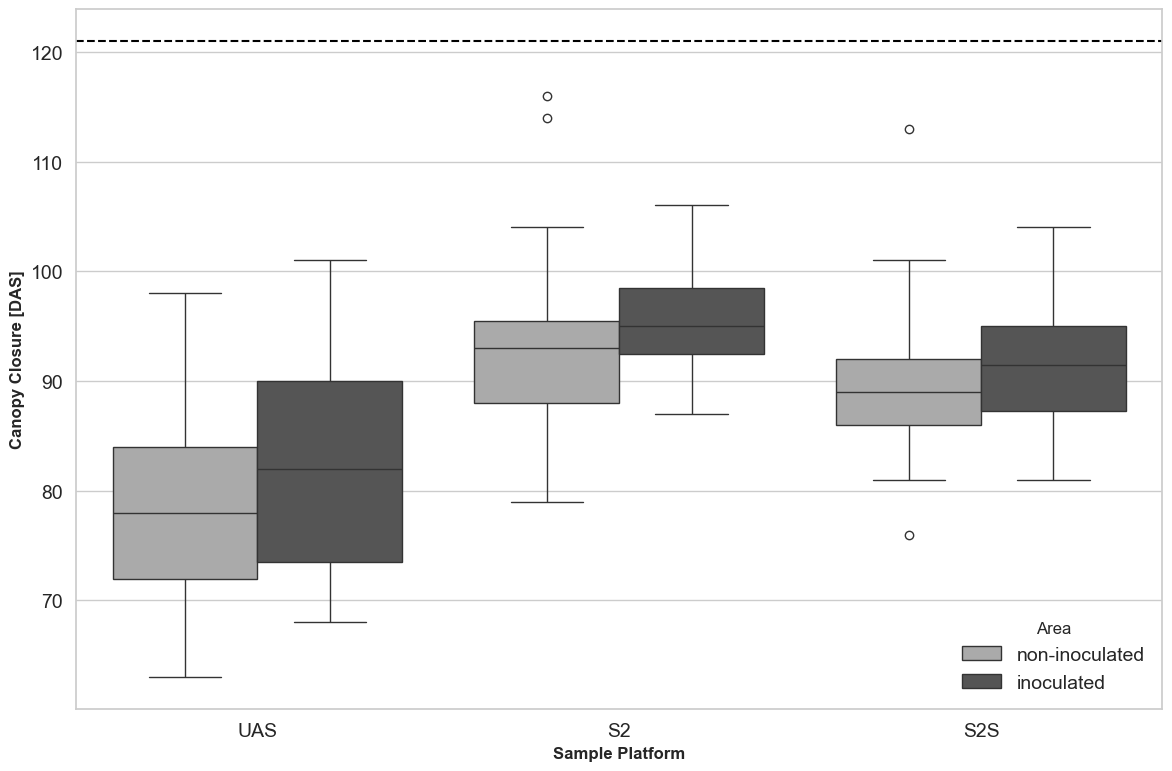

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered = df_untreated[df_untreated['cc'] <= 500]
# Create a boxplot comparing epidemic onset (das) by source and area
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered, x='source', y='cc', hue='area', palette='binary')
plt.axhline(y=121, color='black', linestyle='--')
#sns.stripplot(x='source', y='cc',
#              data=df_filtered,
#              hue='area',
#              marker='o',
#              alpha=0.5)
plt.xlabel('Sample Platform', fontsize=12, fontweight='bold')
plt.ylabel('Canopy Closure [DAS]', fontsize=12, fontweight='bold')
plt.title('', fontsize=14, fontweight='bold')
plt.legend(title='Area', frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(out, f"{current_date}_boxplot_cc_cercospoRa.png"), dpi=600, bbox_inches='tight')
plt.show()



In [26]:
print("Success")

Success
